In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from phase_generator import *

/Users/pjanin/Documents/GitHub/FATMOSS/misc.py:21: UserWarning: CuPy is not installed. Using NumPy backend.
  warnings.warn('CuPy is not installed. Using NumPy backend.')


Initalize simulation parameters and the simulator

In [3]:
# Parameters
D  = 8.0  # Size of the phase screen [m]
r0 = 0.1  # Fried parameter [m]
L0 = 25.0 # Outer scale [m]

dx = r0 / 3.0 # Spatial sampling interval [m/pixel], make sure r0 is Nyquist sampled
dt = 0.001 # Time step [s/step]

wind_speed = 40 # [m/s]
wind_direction = 15 # [degree]
boiling_factor = 500 # [a.u], need to figure them out

screen_generator = CascadedPhaseGenerator(D, dx, dt, batch_size=config['batch_size'], n_cascades=3)
screen_generator.AddLayer(1.0, r0, L0, wind_speed, wind_direction, boiling_factor)
# screen_generator.AddLayer(0.5, r0/2., L0, wind_speed*2, wind_direction*4, boiling_factor)

Generate 1000 atmospheric phase screens. Even though the phase screens here are accesses one by one, the batch with $N_{screens}$ is pre-generated. Then, the screens are read from it.

In [4]:
if GPU_flag:
    start = cp.cuda.Event()
    end   = cp.cuda.Event()

total_time = 0
screens_cascade = []

for i in tqdm(range(1000)):
    if GPU_flag:
        start.record()
    else:
        start = time.time()
        
    screens_cascade.append(screen_generator.GetScreenByTimestep(i))
    
    if GPU_flag:
        end.record()
        end.synchronize()
        total_time += cp.cuda.get_elapsed_time(start, end)  # Time in [ms]
    else:
        end = time.time()
        total_time += (end-start) * 1000

screens_cascade = xp.dstack(screens_cascade)

print(f"Total elapsed time: {np.round(total_time/1e3,1)} [s]")
print(f"Time per sreen: {np.round(total_time/screen_generator.num_screens).astype(xp.uint16)} [ms]")

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: need at least one array to stack

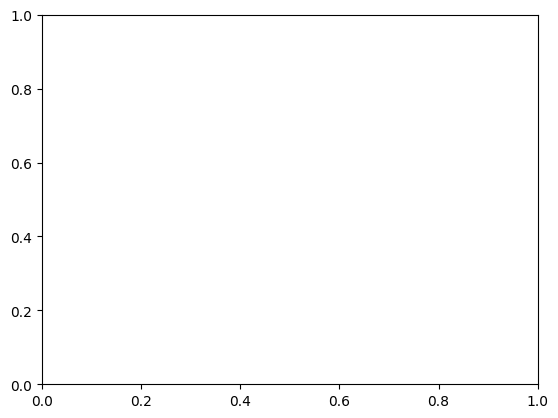

/var/folders/7t/065x1t751d328nctyly8v49r0000gn/T/ipykernel_15401/2211517937.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [20]:
fig, ax = plt.subplots(1,1)
for i in range(1000):

    plt.show()

    ax.imshow(screens_cascade[:,:,i])
    ax.set_title(i)
    
    plt.pause(.001)

ax.imshow(screens_cascade[:,:,i])
fig.show()


In [21]:
screen_generator.f

array([[[21.125906 ,  7.041969 ,  2.347323 ],
        [21.03879  ,  7.01293  ,  2.3376434],
        [20.95204  ,  6.984013 ,  2.3280044],
        ...,
        [20.95204  ,  6.984013 ,  2.3280044],
        [21.03879  ,  7.01293  ,  2.3376434],
        [21.125906 ,  7.041969 ,  2.347323 ]],

       [[21.03879  ,  7.01293  ,  2.3376434],
        [20.951311 ,  6.983771 ,  2.3279235],
        [20.864197 ,  6.9547324,  2.3182442],
        ...,
        [20.864197 ,  6.9547324,  2.3182442],
        [20.951311 ,  6.983771 ,  2.3279235],
        [21.03879  ,  7.01293  ,  2.3376434]],

       [[20.95204  ,  6.984013 ,  2.3280044],
        [20.864197 ,  6.9547324,  2.3182442],
        [20.776718 ,  6.9255724,  2.3085241],
        ...,
        [20.776718 ,  6.9255724,  2.3085241],
        [20.864197 ,  6.9547324,  2.3182442],
        [20.95204  ,  6.984013 ,  2.3280044]],

       ...,

       [[20.95204  ,  6.984013 ,  2.3280044],
        [20.864197 ,  6.9547324,  2.3182442],
        [20.776718 ,  

Save as video file

In [4]:
SaveVideo(screens_cascade)

Writing video...


100%|██████████| 1000/1000 [00:05<00:00, 174.49it/s]


Compare the PSD estimated from the series of previously generated screens with a theoretical oversampled PSD

In [5]:
oversampling_factor = 17
_,_,f_over, df_over = screen_generator.freq_array(screen_generator.N*oversampling_factor, dx)

rad2nm = 500.0 / 2.0 / np.pi # [nm/rad]

PSD_ultimate = screen_generator.vonKarmanPSD(f_over, r0, L0) * df_over**2 * rad2nm**2 * oversampling_factor**2

PSD_out = PSD_to_phase(screens_cascade)
if GPU_flag:
    PSD_out = cp.asnumpy(PSD_out)


radialize_PSD(PSD_ultimate, f_over, 'Ultimate PSD')
radialize_PSD(PSD_out, screen_generator.f[...,0], 'Reconstructed PSD')

plt.grid()
plt.title('Theoretical oversampled PSD vs. PSD from phases')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Spatial frequency [1/m]')
plt.ylabel(r'$PSD [nm^2/m^2]$')
plt.show()

NameError: name 'radialize_PSD' is not defined